# Fine-Tuning the CNN on Cancer and Subtype





In [2]:
!pip install tf_keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.0 MB/s eta 0:00:0031m10.2 MB/s eta 0:00:01


In [1]:
import os
import sys
from pathlib import Path

# --- CRITICAL CONFIG ---
# This forces TensorFlow to use the legacy Keras 2 behavior
# which supports your older folder-based models.
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Prevent log clutter
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import pandas as pd
import numpy as np
import tensorflow as tf

# Check that the legacy import works
import tf_keras as keras 

# Setup paths
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from config import THYROID_PATH, MODEL_PATH, RESULTS_PATH

print(f"✅ Environment Ready. TensorFlow version: {tf.__version__}")
print(f"✅ Keras version: {keras.__version__}") # Should say 2.15.x or similar

✅ Environment Ready. TensorFlow version: 2.20.0
✅ Keras version: 2.20.1


In [2]:
FinalPath = Path(THYROID_PATH, 'FinalData.npy')
npz_content = np.load(FinalPath, allow_pickle=True)

# Extract and handle NaNs
X_train = np.nan_to_num(npz_content['X_cancer_train'])
y_train = npz_content['y_cancer_train']

print(f"✅ Data Loaded. X shape: {X_train.shape}, y shape: {y_train.shape}")

# Create output directories
os.makedirs("fit_history", exist_ok=True)
output_folder = Path(RESULTS_PATH, 'Final_1DCNN_Results')
output_folder.mkdir(exist_ok=True)

✅ Data Loaded. X shape: (412, 485577), y shape: (412,)


In [4]:
# --- 1. Define the missing helper function first ---
def get_uncompiled_model(reset_last_layer=False):
    # Construct the path to your saved model folder
    load_path = os.path.join(MODEL_PATH, 'pan-cancer-leaky-relu')
    print(f"Loading base model from: {load_path}")
    
    # Load the model (works with folder format because of tf_keras)
    model = keras.models.load_model(load_path)
    
    # (Optional) Logic to reset layer if needed, based on your previous code
    if reset_last_layer:
        x = model.layers[-2].output
        output = keras.layers.Dense(1, activation='sigmoid', name='output_follicolar')(x)
        model = keras.Model(inputs=model.input, outputs=output)
        
    return model

# --- 2. Define the Subtype Model Builder ---
num_classes = len(np.unique(y_train)) 
print(f"Number of classes detected: {num_classes}")

def get_subtype_model(num_classes):
    # Load the base model without resetting the last layer
    model = get_uncompiled_model(reset_last_layer=False) 
    
    # Extract the features before the old head (second to last layer)
    x = model.layers[-2].output 
    
    # Add new head for multiclass subtypes
    output = keras.layers.Dense(num_classes, activation='softmax', name='subtype_output')(x)
    return keras.Model(inputs=model.input, outputs=output)

# --- 3. Instantiate and Compile ---
model = get_subtype_model(num_classes)

model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    metrics=['accuracy']
)

print("✅ Model compiled successfully.")
model.summary()

Number of classes detected: 2
Loading base model from: /home/Capstone_Team78/Dataset/Models/pan-cancer-leaky-relu


2026-02-14 10:45:37.283768: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✅ Model compiled successfully.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 485577, 1)]          0         []                            
                                                                                                  
 conv1d_12 (Conv1D)          (None, 485577, 16)           96        ['input_2[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 485577, 16)           64        ['conv1d_12[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)  (None, 485577, 16)           0    

In [66]:
#Retrain Base Model for thyroid cancer classification
# Run this in a new cell or terminal if needed
!rm -rf ckpt-thyroid-cancer

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Subtype Data (Ensure keys match your .npz file)
# Note: If your .npz only has 'X_cancer_train', change this line!
if 'X_subtype_train' in npz_content:
    X_train_sub = np.nan_to_num(npz_content['X_subtype_train']).astype('float32')
    y_train_sub = npz_content['y_subtype_train']
else:
    print("⚠️ 'X_subtype_train' not found. Using 'X_cancer_train' from Cell 2.")
    X_train_sub = X_train # defined in Cell 2
    y_train_sub = y_train # defined in Cell 2

# 2. Check how many subtypes we are dealing with
num_classes = len(np.unique(y_train_sub))
print(f"🎯 Training for {num_classes} subtypes.")

# 3. Initialize model (Using the function we defined in Cell 3)
# We don't need 'make_or_restore_model' because we already built 'model' in Cell 3.
# If you want to start fresh, uncomment the next line:
# model = get_subtype_model(num_classes) 

# Define the callback since it wasn't defined in this cell block
early_stopping_cb = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# 4. Train
print("🚀 Starting training...")
subtype_history = model.fit(
    X_train_sub, 
    y_train_sub, 
    batch_size=4, # Low batch size is good for memory
    epochs=30, 
    callbacks=[early_stopping_cb], 
    validation_split=0.2, 
    shuffle=True
)

# 5. Save Results
os.makedirs('fit_history', exist_ok=True)
subtype_df = pd.DataFrame(subtype_history.history)
subtype_df.to_csv(os.path.join('fit_history','thyroid-subtype.csv'))

# 6. Save Model
# FIXED: Use .h5 because we are in Legacy Keras mode
save_path = os.path.join(MODEL_PATH, "thyroid-subtype.h5")
model.save(save_path)

print(f"✅ Subtype Model Training Complete. Model saved to: {save_path}")

🎯 Training for 2 subtypes.
🚀 Starting training...
Epoch 1/30
74/74 [==============================] - 241s 3s/step - loss: 1.0777 - accuracy: 0.7143 - val_loss: 1.2554 - val_accuracy: 0.2838
Epoch 2/30
74/74 [==============================] - 240s 3s/step - loss: 0.9524 - accuracy: 0.7381 - val_loss: 0.4603 - val_accuracy: 0.8378
Epoch 3/30
74/74 [==============================] - 241s 3s/step - loss: 0.6429 - accuracy: 0.8061 - val_loss: 1.1143 - val_accuracy: 0.7703
Epoch 4/30
74/74 [==============================] - 242s 3s/step - loss: 0.4861 - accuracy: 0.8469 - val_loss: 0.5526 - val_accuracy: 0.7703
Epoch 5/30
74/74 [==============================] - 241s 3s/step - loss: 0.4067 - accuracy: 0.8673 - val_loss: 0.5860 - val_accuracy: 0.7703
Epoch 6/30
74/74 [==============================] - 241s 3s/step - loss: 0.4596 - accuracy: 0.8401 - val_loss: 0.5599 - val_accuracy: 0.7838
Epoch 7/30
74/74 [==============================] - 241s 3s/step - loss: 0.3281 - accuracy: 0.8571 - val

/home/Capstone_Team78/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import os

# 1. Use the correct variable name (npz_content)
# Note: Ensure npz_content is loaded. If not, reload it like in Cell 2.
if 'X_subtype_train' in npz_content:
    X_train_sub = np.nan_to_num(npz_content['X_subtype_train']).astype('float32')
    y_train_sub = npz_content['y_subtype_train']
else:
    # Fallback if your npz only has the main train set
    print("⚠️ Using X_cancer_train as fallback.")
    X_train_sub = X_train 
    y_train_sub = y_train

# 2. Check classes
num_subtypes = len(np.unique(y_train_sub))
print(f"🧬 Detected {num_subtypes} thyroid subtypes. Initializing training...")

# 3. Initialize the model using YOUR function from Cell 3
# We use get_subtype_model, not make_or_restore_model
model_subtype = get_subtype_model(num_subtypes)

# Re-compile just to be safe (ensures fresh optimizer state)
model_subtype.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    metrics=['accuracy']
)

# Define callback (in case it wasn't defined in previous cells)
early_stopping_cb = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

# 4. Train
print("🚀 Starting Subtype Training...")
subtype_history = model_subtype.fit(
    X_train_sub,
    y_train_sub, 
    batch_size=4, 
    epochs=30, 
    callbacks=[early_stopping_cb], 
    validation_split=0.2, 
    shuffle=True
)

# 5. Save history and the model
os.makedirs('fit_history', exist_ok=True)
subtype_df = pd.DataFrame(subtype_history.history)
subtype_df.to_csv(os.path.join('fit_history', 'thyroid-subtype.csv'))

# FIXED: Save as .h5 because we are in Legacy Keras mode
save_path = os.path.join(MODEL_PATH, "thyroid-subtype.h5")
model_subtype.save(save_path)

print(f"✅ Subtype Detection Model saved successfully to: {save_path}")

🧬 Detected 2 thyroid subtypes. Initializing training...
Loading base model from: /home/Capstone_Team78/Dataset/Models/pan-cancer-leaky-relu
🚀 Starting Subtype Training...
Epoch 1/30
74/74 [==============================] - 243s 3s/step - loss: 1.0059 - accuracy: 0.7007 - val_loss: 0.4313 - val_accuracy: 0.7838
Epoch 2/30
74/74 [==============================] - 244s 3s/step - loss: 0.5501 - accuracy: 0.7483 - val_loss: 0.7219 - val_accuracy: 0.7703
Epoch 3/30
74/74 [==============================] - 243s 3s/step - loss: 1.0683 - accuracy: 0.7279 - val_loss: 1.5828 - val_accuracy: 0.7703
Epoch 4/30
74/74 [==============================] - 243s 3s/step - loss: 0.7146 - accuracy: 0.7959 - val_loss: 0.5167 - val_accuracy: 0.8243
Epoch 5/30
74/74 [==============================] - 242s 3s/step - loss: 0.4789 - accuracy: 0.8367 - val_loss: 0.6599 - val_accuracy: 0.7838
Epoch 6/30
74/74 [==============================] - 244s 3s/step - loss: 0.4174 - accuracy: 0.8401 - val_loss: 0.8473 - val_

/home/Capstone_Team78/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2,shuffle=True, stratify=y)

from collections import Counter
X_train_fill = SimpleImputer(strategy='constant').fit_transform(X_train,y_train)
X_train_over,y_train_over = over.fit_resample(X_train_fill,y_train)
X_train_under,y_train_under = under.fit_resample(X_train_over,y_train_over)

X_test_fill = SimpleImputer(strategy='constant').fit_transform(X_test,y_test)
X_test_over,y_test_over = over.fit_resample(X_test_fill,y_test)
X_test_under,y_test_under = under.fit_resample(X_test_over,y_test_over)

print(Counter(y_train))
print(Counter(y_train_under))

print(Counter(y_test))
print(Counter(y_test_under))



🔍 Generating predictions for evaluation...
12/12 [==============================] - 33s 3s/step


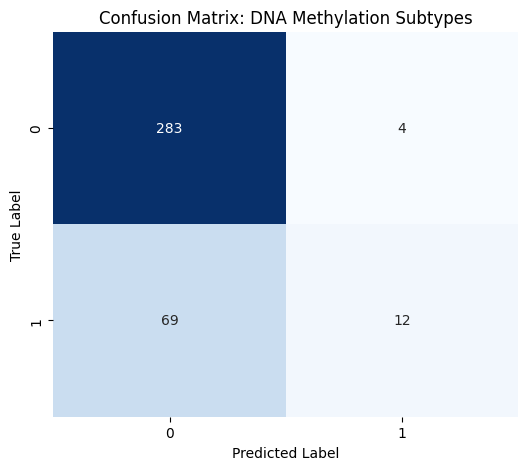


📝 Classification Report:

              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89       287
         1.0       0.75      0.15      0.25        81

    accuracy                           0.80       368
   macro avg       0.78      0.57      0.57       368
weighted avg       0.79      0.80      0.75       368



In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate Predictions
print("🔍 Generating predictions for evaluation...")
# We use the trained 'model_subtype' from Cell 6
y_pred_probs = model_subtype.predict(X_train_sub) 
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Confusion Matrix
cm = confusion_matrix(y_train_sub, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: DNA Methylation Subtypes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Classification Report
print("\n📝 Classification Report:\n")
print(classification_report(y_train_sub, y_pred))

In [8]:
from sklearn.utils import class_weight
import numpy as np

# 1. Calculate Class Weights
# This automatically assigns higher weight to the minority class (1)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_sub),
    y=y_train_sub
)

# Convert to dictionary format required by Keras
class_weights_dict = dict(enumerate(class_weights_vals))

print(f"⚖️ Computed Class Weights: {class_weights_dict}")
# Example output might look like: {0: 0.64, 1: 2.27}
# This means the model gets ~3.5x more penalty for missing a Class 1 sample.

# 2. Re-Initialize Model (Start Fresh)
# We must reset the model so it doesn't remember the "lazy" strategy
model_subtype_weighted = get_subtype_model(num_subtypes)

model_subtype_weighted.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    metrics=['accuracy']
)

# 3. Train with Class Weights
print("🚀 Retraining with Class Weights...")
weighted_history = model_subtype_weighted.fit(
    X_train_sub,
    y_train_sub,
    batch_size=4,
    epochs=30,
    callbacks=[early_stopping_cb],
    validation_split=0.2,
    shuffle=True,
    class_weight=class_weights_dict  # <--- KEY ADDITION
)

# 4. Save the Weighted Model
save_path_weighted = os.path.join(MODEL_PATH, "thyroid-subtype-weighted.h5")
model_subtype_weighted.save(save_path_weighted)
print(f"✅ Weighted Model Saved to: {save_path_weighted}")

⚖️ Computed Class Weights: {0: np.float64(0.6411149825783972), 1: np.float64(2.271604938271605)}
Loading base model from: /home/Capstone_Team78/Dataset/Models/pan-cancer-leaky-relu
🚀 Retraining with Class Weights...
Epoch 1/30
74/74 [==============================] - 242s 3s/step - loss: 1.0930 - accuracy: 0.5884 - val_loss: 0.4004 - val_accuracy: 0.8243
Epoch 2/30
74/74 [==============================] - 242s 3s/step - loss: 0.9525 - accuracy: 0.6701 - val_loss: 0.4169 - val_accuracy: 0.8378
Epoch 3/30
74/74 [==============================] - 243s 3s/step - loss: 1.1119 - accuracy: 0.6531 - val_loss: 0.5786 - val_accuracy: 0.7703
Epoch 4/30
74/74 [==============================] - 243s 3s/step - loss: 0.8315 - accuracy: 0.7449 - val_loss: 0.5962 - val_accuracy: 0.7568
Epoch 5/30
74/74 [==============================] - 244s 3s/step - loss: 1.1288 - accuracy: 0.7075 - val_loss: 0.5994 - val_accuracy: 0.7838
Epoch 6/30
74/74 [==============================] - 244s 3s/step - loss: 0.7632

/home/Capstone_Team78/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


⚖️ Class Weights Active: {0: np.float64(0.6411149825783972), 1: np.float64(2.271604938271605)}
Loading base model from: /home/Capstone_Team78/Dataset/Models/pan-cancer-leaky-relu
🚀 Retraining with Class Weights...
Epoch 1/30
74/74 [==============================] - 240s 3s/step - loss: 1.3073 - accuracy: 0.5816 - val_loss: 0.6109 - val_accuracy: 0.7432
Epoch 2/30
74/74 [==============================] - 244s 3s/step - loss: 1.0134 - accuracy: 0.6259 - val_loss: 0.9312 - val_accuracy: 0.6081
Epoch 3/30
74/74 [==============================] - 245s 3s/step - loss: 1.0350 - accuracy: 0.6905 - val_loss: 0.5599 - val_accuracy: 0.7703
Epoch 4/30
74/74 [==============================] - 247s 3s/step - loss: 1.0341 - accuracy: 0.7143 - val_loss: 0.9216 - val_accuracy: 0.7838
Epoch 5/30
74/74 [==============================] - 243s 3s/step - loss: 0.8388 - accuracy: 0.7415 - val_loss: 1.6945 - val_accuracy: 0.4459
Epoch 6/30
74/74 [==============================] - 250s 3s/step - loss: 0.7355 -

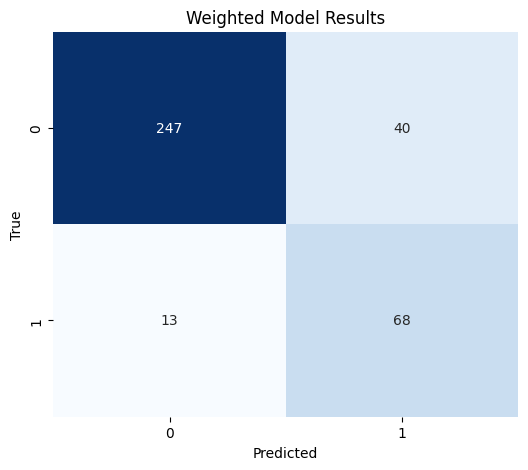

              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90       287
         1.0       0.63      0.84      0.72        81

    accuracy                           0.86       368
   macro avg       0.79      0.85      0.81       368
weighted avg       0.88      0.86      0.86       368



In [10]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# --- 1. Compute Class Weights ---
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_sub),
    y=y_train_sub
)
class_weights_dict = dict(enumerate(class_weights_vals))
print(f"⚖️ Class Weights Active: {class_weights_dict}")

# --- 2. Force-Reset the Model ---
# We use a new name 'final_model' to avoid conflicts
final_model = get_subtype_model(num_subtypes)

final_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=3e-5), 
    metrics=['accuracy']
)

# --- 3. Train with Weights ---
print("🚀 Retraining with Class Weights...")
history = final_model.fit(
    X_train_sub,
    y_train_sub,
    batch_size=4,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping_cb],
    class_weight=class_weights_dict, # Applying weights here
    verbose=1
)

# --- 4. IMMEDIATE EVALUATION ---
print("\n🔍 Generating new predictions...")
y_pred_probs = final_model.predict(X_train_sub) 
y_pred_new = np.argmax(y_pred_probs, axis=1)

# Plot
cm = confusion_matrix(y_train_sub, y_pred_new)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Weighted Model Results')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Report
print(classification_report(y_train_sub, y_pred_new))

✅ Optimized Model Architecture defined.
⚖️ Class Weights: {0: np.float64(0.6411149825783972), 1: np.float64(2.271604938271605)}
Loading base model from: /home/Capstone_Team78/Dataset/Models/pan-cancer-leaky-relu
🚀 Training Optimized Model (High Regularization)...
Epoch 1/40
37/37 [==============================] - 262s 7s/step - loss: 2.0446 - accuracy: 0.5884 - val_loss: 1.7221 - val_accuracy: 0.4730
Epoch 2/40
37/37 [==============================] - 258s 7s/step - loss: 1.6643 - accuracy: 0.6259 - val_loss: 1.5634 - val_accuracy: 0.5000
Epoch 3/40
37/37 [==============================] - 263s 7s/step - loss: 1.4594 - accuracy: 0.6803 - val_loss: 1.3497 - val_accuracy: 0.7838
Epoch 4/40
37/37 [==============================] - 267s 7s/step - loss: 1.3453 - accuracy: 0.6939 - val_loss: 1.5057 - val_accuracy: 0.3649
Epoch 5/40
37/37 [==============================] - 266s 7s/step - loss: 1.2686 - accuracy: 0.6429 - val_loss: 1.1209 - val_accuracy: 0.7973
Epoch 6/40
37/37 [=============

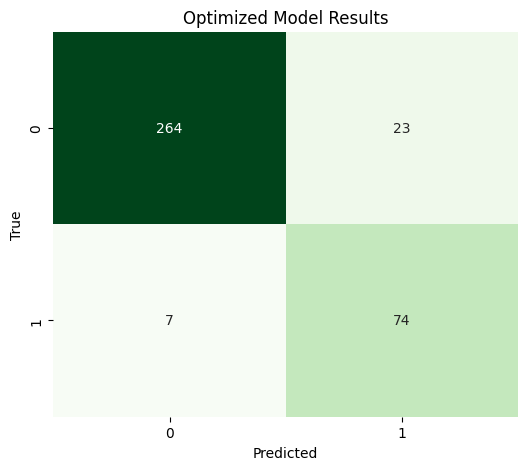

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95       287
         1.0       0.76      0.91      0.83        81

    accuracy                           0.92       368
   macro avg       0.87      0.92      0.89       368
weighted avg       0.93      0.92      0.92       368



/home/Capstone_Team78/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Optimized Model Saved to: /home/Capstone_Team78/Dataset/Models/thyroid-subtype-optimized.h5


In [11]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

# --- 1. Define the Optimized Model Architecture ---
def get_optimized_subtype_model(num_classes):
    # Load base model (using your existing function)
    base_model = get_uncompiled_model(reset_last_layer=False)
    
    # Extract features from the second-to-last layer
    x = base_model.layers[-2].output 
    
    # --- Optimization: Regularization & Dropout ---
    # Dropout 50%: Randomly disables half the neurons to prevent memorization
    x = keras.layers.Dropout(0.5)(x) 
    
    # L2 Regularization: Punishes large weights to keep the model simple
    x = keras.layers.Dense(
        64, 
        activation='relu', 
        kernel_regularizer=regularizers.l2(0.01) 
    )(x)
    
    # Dropout 30%: A second safety layer
    x = keras.layers.Dropout(0.3)(x)
    
    # Final Output Head
    output = keras.layers.Dense(
        num_classes, 
        activation='softmax', 
        name='subtype_output'
    )(x)
    
    return keras.Model(inputs=base_model.input, outputs=output)

print("✅ Optimized Model Architecture defined.")

# --- 2. Setup & Compile ---
# Calculate Class Weights (Critical for your imbalance)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_sub),
    y=y_train_sub
)
class_weights_dict = dict(enumerate(class_weights_vals))
print(f"⚖️ Class Weights: {class_weights_dict}")

# Initialize the new model
final_model_v2 = get_optimized_subtype_model(num_subtypes)

final_model_v2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=2e-5), # Lower LR for stability
    metrics=['accuracy']
)

# Define Early Stopping
early_stopping_cb = EarlyStopping(
    monitor='val_loss', 
    patience=8, # Increased patience slightly for the slower learning rate
    restore_best_weights=True,
    verbose=1
)

# --- 3. Train ---
print("🚀 Training Optimized Model (High Regularization)...")
history_v2 = final_model_v2.fit(
    X_train_sub,
    y_train_sub,
    batch_size=8, 
    epochs=40,    
    validation_split=0.2,
    callbacks=[early_stopping_cb],
    class_weight=class_weights_dict, 
    verbose=1
)

# --- 4. Evaluate Immediately ---
print("\n🔍 Evaluating Optimized Model...")
y_pred_probs = final_model_v2.predict(X_train_sub) 
y_pred_v2 = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_train_sub, y_pred_v2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False) 
plt.title('Optimized Model Results')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_train_sub, y_pred_v2))

# --- 5. Save the Best Model ---
save_path_v2 = os.path.join(MODEL_PATH, "thyroid-subtype-optimized.h5")
final_model_v2.save(save_path_v2)
print(f"✅ Optimized Model Saved to: {save_path_v2}")

In [12]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 11.5 MB/s eta 0:00:0031m11.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 10.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.2
    Uninstalling numpy-2.4.2:
      Successfully uninstalled numpy-2.4.2
